# Statistical Methods for Machine Learning project

In [24]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform, util
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
from PIL import Image
import pdb
import random
import numpy.random as npr

import math
import kagglehub
import shutil

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cpu")#("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cpu


In [25]:
!pip install torchmetrics

# Creation of training and test folders

In [26]:
if not os.path.exists('train'):
    # Download latest version
    path = kagglehub.dataset_download("drgfreeman/rockpaperscissors")
    print("Path to dataset files:", path)

    # creation of training and test folders
    ratio = 0.9
    subfolders = ['rock','paper','scissors']

    os.makedirs('train', exist_ok=True)
    os.makedirs('test', exist_ok=True)
    for subfolder in subfolders:
        subpath = os.path.join(path, subfolder)
        os.makedirs(os.path.join('train',subfolder))
        os.makedirs(os.path.join('test',subfolder))

        imgs = os.listdir(subpath)
        random.shuffle(imgs)

        train_size = int(ratio * len(imgs))
        test_size = len(imgs) - train_size

        train_imgs = imgs[:train_size]
        test_imgs = imgs[train_size:]

        for i in train_imgs:
            shutil.copy(os.path.join(subpath,i), os.path.join('train',subfolder,i))
        for i in test_imgs:
            shutil.copy(os.path.join(subpath,i), os.path.join('test',subfolder,i))




(200, 300, 3)


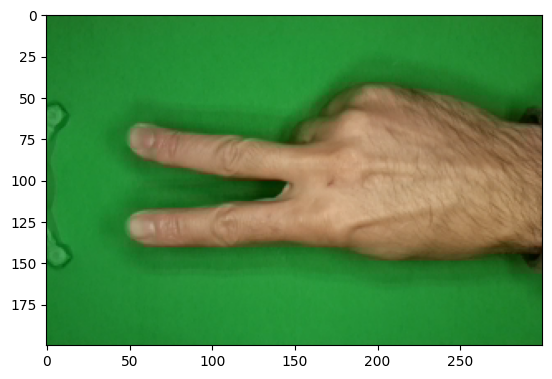

In [27]:
plt.figure()
folder = os.path.join('train', random.choice(['rock','paper','scissors']))
img_name = random.choice(os.listdir(folder))
img = io.imread(os.path.join(folder,img_name))
print( img.shape)
plt.imshow(img)
plt.show()

# Transformation and data augmentation

In [129]:
# no need to resize since all images have the same dimension (?)
# test set only transformed to tensor
# training set augmented with random transformations
IMG_MEAN = [0.485, 0.456, 0.406]
IMG_STD = [0.229, 0.224, 0.225]
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((100,150)),
    transforms.ColorJitter(brightness=0.3,hue=0.3,saturation=0.3,contrast=0.2),
    #transforms.RandomPerspective(distortion_scale=0.1, p=0.2),
    transforms.Normalize(mean=IMG_MEAN, std=IMG_STD),
])
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((100,150)),
    transforms.ColorJitter(brightness=0.3,hue=0.3,saturation=0.3,contrast=0.2),
    transforms.RandomRotation(degrees=(-20,20)),
    transforms.RandomVerticalFlip(p=0.5),
    #transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
    transforms.Normalize(mean=IMG_MEAN, std=IMG_STD),
])

gen_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((100,150)),
    transforms.Normalize(mean=IMG_MEAN, std=IMG_STD),
])

In [29]:
def unnormalize(img):
    img = img * IMG_STD + IMG_MEAN
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..0.8610293744802475].


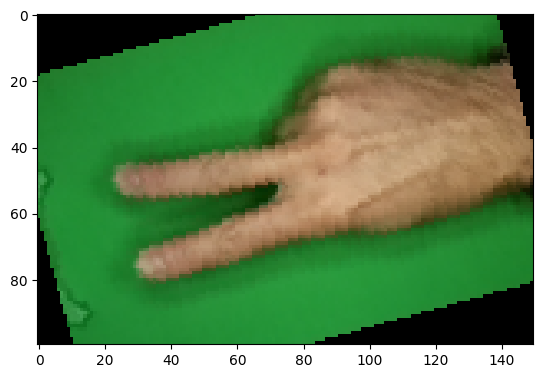

In [30]:
transformed_img = train_transform(img)
plt.imshow(unnormalize(transformed_img.permute(1,2,0).numpy()))
plt.show()

# DataLoader creation

In [130]:
batch_size = 9
train_dataset = datasets.ImageFolder(root='train', transform=train_transform)
test_dataset = datasets.ImageFolder(root='test', transform=test_transform)

train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=batch_size)
print('Number of training batches: {}'.format(len(train_dl)))
print('Number of test batches: {}'.format(len(test_dl)))
classes = train_dataset.classes

Number of training batches: 219
Number of test batches: 25


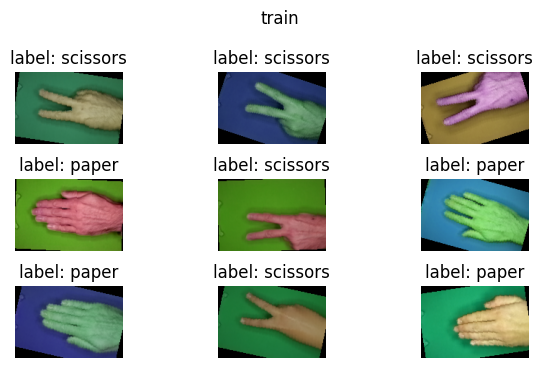

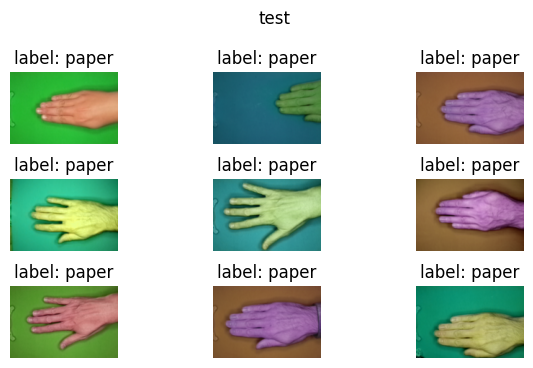

In [131]:
def show_batch(x, y, yh=None, title=None):
    col = math.floor(math.sqrt(len(x)))
    row = col+1
    for i in range(len(x)):
        ax = plt.subplot(row,col,i+1)
        plt.tight_layout()
        subtitle = 'label: ' + classes[int(y[i])]
        if (yh is not None):
            subtitle += '\nprediction: ' + classes[int(np.argmax(yh[i]))]
        ax.set_title(subtitle)
        ax.axis('off')
        plt.imshow(unnormalize(x[i].permute(1,2,0).numpy()).clip(0, 1))
    if (title):
        plt.subplots_adjust(top=0.85)
        plt.suptitle(title)
    plt.show()

show_batch(*next(iter(train_dl)), title='train')
show_batch(*next(iter(test_dl)), title='test')

# Training function

In [100]:
from tqdm import tqdm
import torchmetrics
from torchmetrics import Accuracy, Precision, Recall

In [71]:
def train_model(model, dataloaders,  criterion, optimizer, scheduler, num_epochs=25, verbose=True):
    stats = {
            'train_loss': [],
            'test_loss': [],
            'test_acc': [],
            'test_rec': [],
            'test_prec': [],
            'elapsed_time': 0,
            'best_accuracy':0
    }
    for epoch in range(num_epochs):
        dl = dataloaders['train']
        if(verbose):
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-'*10)
            dl = tqdm(dl,leave=False)


        # TRAIN
        running_loss = 0
        start_time = time.time()
        model.train()
        for batch_index, (images, labels) in enumerate(dl):
            optimizer.zero_grad()
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            running_loss += loss.item()*images.size(0)
            optimizer.step()
        stats['elapsed_time'] += time.time() - start_time
        epoch_loss = running_loss / len(dataloaders['train'])
        stats['train_loss'].append(epoch_loss)

        # test
        acc = Accuracy(task="multiclass",num_classes=len(classes)).to(device)
        precision = Precision(task="multiclass", num_classes=len(classes), average='macro').to(device)
        recall = Recall(task="multiclass", num_classes=len(classes), average='macro').to(device)

        model.eval()
        with torch.no_grad():
            running_loss = 0
            for images, labels in dataloaders['test']:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()*images.size(0)
                _, preds = torch.max(outputs, 1)
                acc(preds, labels)
                precision(preds, labels)
                recall(preds, labels)

            test_loss = running_loss / len(dataloaders['test'])
            test_accuracy = acc.compute()
            test_precision = precision.compute()
            test_recall = recall.compute()

            stats['test_loss'].append(test_loss)
            stats['test_acc'].append(test_accuracy.to('cpu'))
            stats['test_rec'].append(test_recall.to('cpu'))
            stats['test_prec'].append(test_precision.to('cpu'))

            if(test_accuracy > stats['best_accuracy']):
                stats['best_accuracy'] = test_accuracy
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(best_model_wts, 'best_model.pt')

        if(verbose):
            print(f"Train loss: {epoch_loss:.4f}")
            print(f"Test loss: {test_loss:.4f}")
            print(f"Test accuracy: {test_accuracy:.4f}")
            print(f"Test precision: {test_precision:.4f}")
            print(f"Test recall: {test_recall:.4f}")

    model.load_state_dict(best_model_wts)
    return stats

In [133]:
from sklearn.model_selection import KFold

def cross_val(model_class, model_params, dataset,  criterion, optimizer_class, scheduler_class, lr=1e-3,num_epochs=25, k=5):
    kf = KFold(n_splits=k, shuffle=True)
    stats = {}

    for fold, (train_idx, val_idx) in tqdm(enumerate(kf.split(dataset))):
        # it is important to reinitialize the model
        net = model_class(*model_params)
        net.to(device)

        # Initialize optimizer and scheduler inside the loop for each fold
        optimizer = optimizer_class(net.parameters(), lr=lr) # Initialize optimizer
        scheduler = scheduler_class(optimizer, step_size=7, gamma=0.1) # Initialize scheduler

        # note that here the "random" means that the indices will be permuted each time
        # however they will always be the same, only their order will change e.g (0,1,2) - (1,0,2) - (2,0,1) -...
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)

        train_dl = DataLoader(dataset, batch_size=batch_size, sampler=train_subsampler)
        val_dl = DataLoader(dataset, batch_size=batch_size, sampler=val_subsampler)

        st = train_model(net, {'train': train_dl, 'test': val_dl},  criterion, optimizer, scheduler, num_epochs=num_epochs, verbose=False)
        for s in st:
            if s not in stats:
                stats[s] = []
            stats[s].append(st[s])
        #plot_stats(st)
    return stats
        # plot_stats(s)

In [145]:
def nested_cv(model_class, hyperparams, dataset,  criterion, optimizer_class, scheduler_class, k):
    grid = ParameterGrid(hyperparams)
    kf = KFold(n_splits=k, shuffle=True)

    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)

        train_dl = DataLoader(dataset, batch_size=batch_size, sampler=train_subsampler)
        val_dl = DataLoader(dataset, batch_size=batch_size, sampler=val_subsampler)

        for theta in tqdm(grid):
            s = cross_val(model_class,theta['model_params'], dataset,  criterion, optimizer_class, scheduler_class, num_epochs=10, lr = theta['lr'])
            plot_stats(s)
        #TODO make cross_vall return all the stats, because here i would need loss not avg accuracy
        #TODO think how to pass nested_cv the hyperparameters.

# Graph function

In [37]:
def plot_stats(stats, title=''):
    if (len(np.shape(stats['train_loss'])) == 1 ):
        fig = plt.figure(figsize=(15,5))
        ax = plt.subplot(1,2,1)
        ax.plot(stats['train_loss'], 'bo-', label='train loss')
        ax.plot(stats['test_loss'], 'r+-', label='test loss')
        ax.set_title('Loss')
        ax.legend()

        ax2 = plt.subplot(1,2,2)
        ax2.plot(stats['test_acc'], label='test accuracy')
        ax2.plot(stats['test_rec'], label='test recall')
        ax2.plot(stats['test_prec'], label='test precision')
        ax2.set_title('Metrics')
        ax2.legend()
    else:
        fig = plt.figure(figsize=(15,5))
        ax = plt.subplot(1,2,1)
        for i, trn in enumerate(stats['train_loss']):
            label = 'train loss' if i == 0 else ''
            ax.plot(trn, 'bo-', label=label)
        for i, tst in enumerate(stats['test_loss']):
            label = 'test loss' if i == 0 else ''
            ax.plot(tst, 'r+-', label=label)
        ax.set_title('Loss')
        ax.legend()

        ax2 = plt.subplot(1,2,2)
        for i, acc in enumerate(stats['test_acc']):
            label = 'test accuracy' if i == 0 else ''
            ax2.plot(acc,'gs-', label=label)
        for i, rec in enumerate(stats['test_rec']):
            label = 'test recall' if i == 0 else ''
            ax2.plot(rec, 'yd-', label=label)
        for i, prec in enumerate(stats['test_prec']):
            label = 'test precision' if i == 0 else ''
            ax2.plot(prec, '^-',color='orange', label=label)

        ax2.set_title('Metrics')
        ax2.legend()

    if (title):
        plt.suptitle(title)

    fig.tight_layout()
    plt.show()

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def cm_plot(model, dl):
    y = []
    y_hat = []
    classes = dl.dataset.classes

    with torch.set_grad_enabled(False):
        for img, lbls in dl:
            output = net(img.to(device).float()).to('cpu').float()
            y.extend(lbls)
            pred = output.data.max(1, keepdim=True)[1]
            y_hat.extend(pred)

    cm = confusion_matrix(y, y_hat, labels=range(len(classes)))
    ConfusionMatrixDisplay(cm,display_labels=classes).plot()
    plt.show()

In [83]:
def show_misclassified(model, dl):
    wrong = []
    classes = dl.dataset.classes

    with torch.set_grad_enabled(False):
        for img, lbls in dl:
            output = net(img.to(device).float()).to('cpu').float()
            pred = output.data.max(1, keepdim=True)[1]
            zipped = list(zip(img,lbls,pred))
            for z in zipped:
                if (int(z[1]) != int(z[2])):
                    wrong.append(z)
    x,y,yh = zip(*wrong)
    for i in range(len(x)):
        plt.title('label: ' + classes[int(y[i])] + '\nprediction: ' + classes[int(yh[i])])
        plt.axis('off')
        plt.imshow(unnormalize(x[i].permute(1,2,0).numpy()).clip(0, 1))
        plt.show()
    #show_batch(list(x),list(y),list(yh), title='wrong predictions')

# Network definition

In [40]:
class KissNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(25*37*3, 3)
    def forward(self, x):
        x = transforms.Resize((25,37))(x)
        x = x.flatten(start_dim=1)
        x = self.fc(x)
        return x

In [148]:
# Extremely simple net
class EzNet(nn.Module):
    def __init__(self, kernel_size=5, stride=2):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8,kernel_size=kernel_size,stride=stride,padding=1)
        self.conv2 = nn.Conv2d(8,16,kernel_size=kernel_size,stride=stride,padding=1)
        self.pool = nn.MaxPool2d(2,2)

        self.fc1 = nn.LazyLinear(84)
        self.fc2 = nn.Linear(84,3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.flatten(start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [42]:
class DeepNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1   = nn.Conv2d(3,6,kernel_size=11,stride=1,padding=2)
        self.conv2   = nn.Conv2d(6,12,kernel_size=5,stride=1,padding=2)
        self.conv2_2 = nn.Conv2d(12,16,kernel_size=5,stride=1,padding=2)
        self.conv3   = nn.Conv2d(16,24,kernel_size=5,stride=1,padding=2)
        self.conv3_2 = nn.Conv2d(24,32,kernel_size=5,stride=1,padding=2)

        self.norm2 = nn.BatchNorm2d(16)
        self.norm3 = nn.BatchNorm2d(32)

        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(6336,128)
        self.fc2 = nn.Linear(128,64)
        self.fc3 = nn.Linear(64,3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = self.pool(F.relu(self.conv2_2(x)))
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv3_2(x)))
        x = x.flatten(start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [43]:
# Simple net
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16,kernel_size=3,stride=1,padding=1)
        self.conv2 = nn.Conv2d(16,32,kernel_size=3,stride=1,padding=1)
        self.pool = nn.MaxPool2d(2,2)

        self.fc1 = nn.Linear(29600,128)
        self.fc2 = nn.Linear(128,3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.flatten(start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [44]:
# General net
class GeneralNet(nn.Module):
    def __init__(self):
        super().__init__()


# Experiments

Epoch 0/9
----------


Train loss: 9.2652
Test loss: 7.3873
Test accuracy: 0.7091
Test precision: 0.7091
Test recall: 0.7103
Epoch 1/9
----------


Train loss: 8.4750
Test loss: 7.8013
Test accuracy: 0.7000
Test precision: 0.6997
Test recall: 0.7004
Epoch 2/9
----------


Train loss: 8.7856
Test loss: 6.9146
Test accuracy: 0.6773
Test precision: 0.7228
Test recall: 0.6786
Epoch 3/9
----------


Train loss: 7.8990
Test loss: 6.1544
Test accuracy: 0.7273
Test precision: 0.7297
Test recall: 0.7279
Epoch 4/9
----------


Train loss: 8.3071
Test loss: 6.9179
Test accuracy: 0.7091
Test precision: 0.7285
Test recall: 0.7112
Epoch 5/9
----------


Train loss: 8.0599
Test loss: 5.9278
Test accuracy: 0.7182
Test precision: 0.7236
Test recall: 0.7192
Epoch 6/9
----------


Train loss: 8.9054
Test loss: 5.8745
Test accuracy: 0.7682
Test precision: 0.7691
Test recall: 0.7678
Epoch 7/9
----------


Train loss: 8.3275
Test loss: 5.6858
Test accuracy: 0.7818
Test precision: 0.7816
Test recall: 0.7819
Epoch 8/9
----------


Train loss: 8.6853
Test loss: 6.3747
Test accuracy: 0.7364
Test precision: 0.7423
Test recall: 0.7364
Epoch 9/9
----------


Train loss: 8.3132
Test loss: 6.2550
Test accuracy: 0.7773
Test precision: 0.7781
Test recall: 0.7779


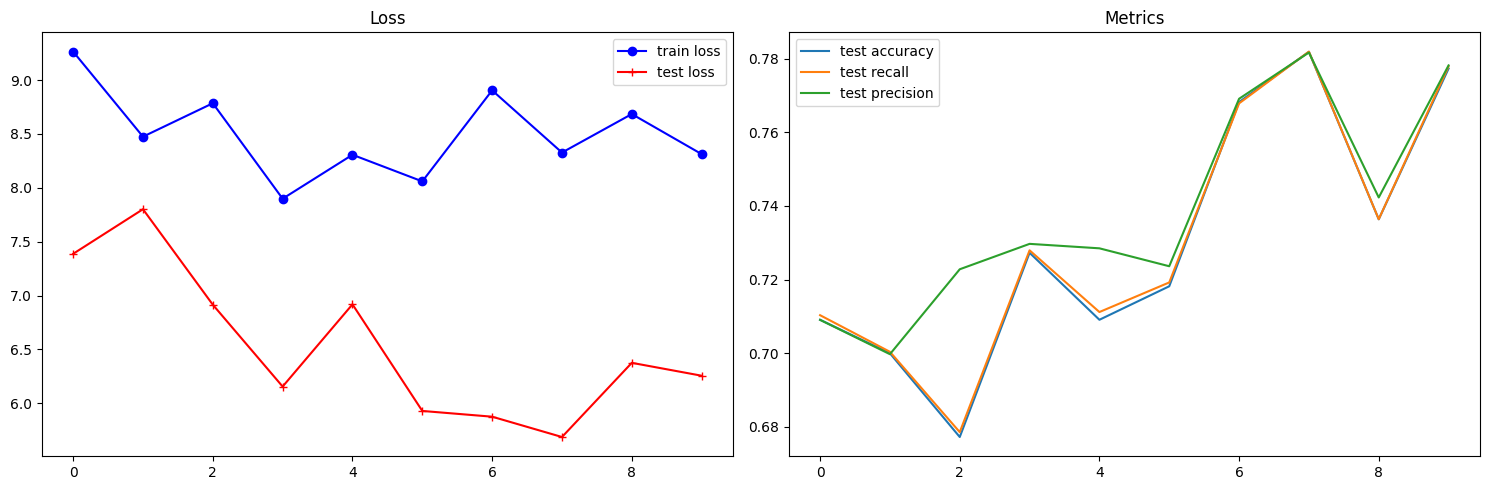

116.66706585884094


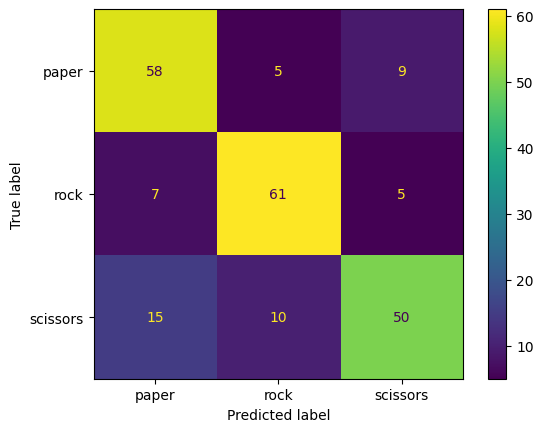

Epoch 0/9
----------


Train loss: 8.1128
Test loss: 3.6879
Test accuracy: 0.8273
Test precision: 0.8485
Test recall: 0.8252
Epoch 1/9
----------


Train loss: 2.6564
Test loss: 0.7880
Test accuracy: 0.9682
Test precision: 0.9690
Test recall: 0.9677
Epoch 2/9
----------


Train loss: 1.6821
Test loss: 1.7711
Test accuracy: 0.9318
Test precision: 0.9403
Test recall: 0.9327
Epoch 3/9
----------


Train loss: 1.1404
Test loss: 0.6102
Test accuracy: 0.9818
Test precision: 0.9825
Test recall: 0.9819
Epoch 4/9
----------


Train loss: 0.9552
Test loss: 1.7166
Test accuracy: 0.9409
Test precision: 0.9424
Test recall: 0.9410
Epoch 5/9
----------


Train loss: 0.8961
Test loss: 0.7294
Test accuracy: 0.9682
Test precision: 0.9689
Test recall: 0.9685
Epoch 6/9
----------


Train loss: 0.7357
Test loss: 0.2050
Test accuracy: 0.9909
Test precision: 0.9909
Test recall: 0.9909
Epoch 7/9
----------


Train loss: 0.9725
Test loss: 0.3496
Test accuracy: 0.9773
Test precision: 0.9776
Test recall: 0.9769
Epoch 8/9
----------


Train loss: 0.6757
Test loss: 0.3391
Test accuracy: 0.9864
Test precision: 0.9867
Test recall: 0.9864
Epoch 9/9
----------


KeyboardInterrupt: 

In [136]:
times = {}
for model in [KissNet, DeepNet, EzNet, SimpleNet]:
    net = model()
    net.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer_ft = optim.Adam(net.parameters(), lr=1e-3)
    # An lr strategy which decreases lr by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

    dls = {'train' : train_dl, 'test': test_dl}
    stats = train_model(net, dls, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)
    plot_stats(stats)
    print(stats['elapsed_time'])
    times[model.__name__] = stats['elapsed_time']
    cm_plot(net, test_dl)

plt.bar(times.keys(), times.values())
plt.show()


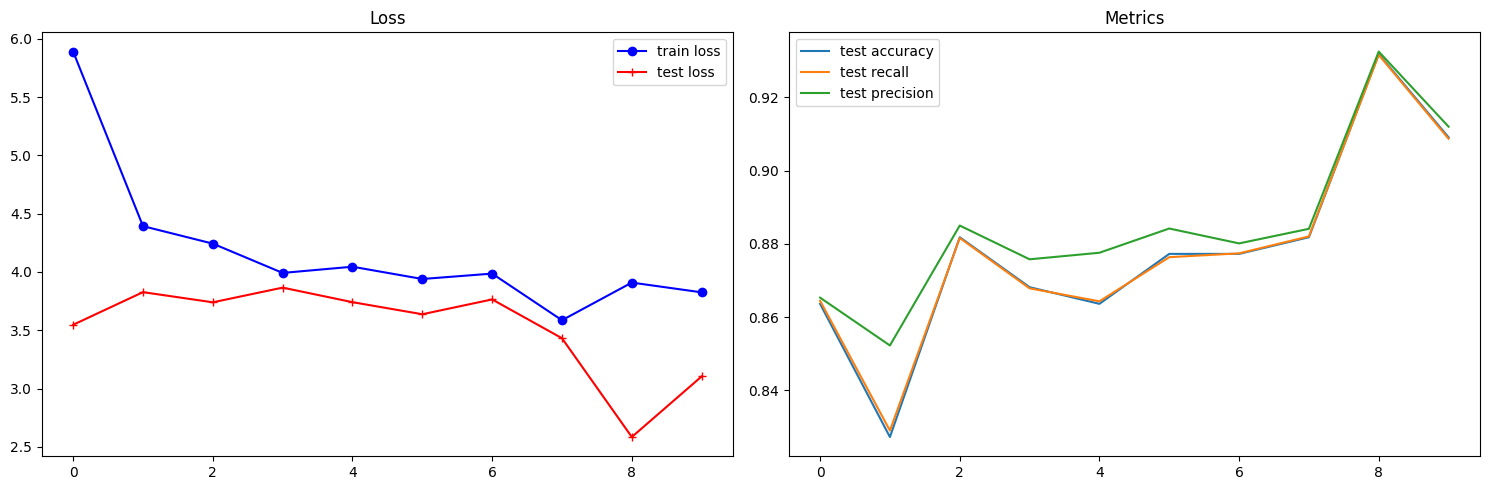

77.10022234916687


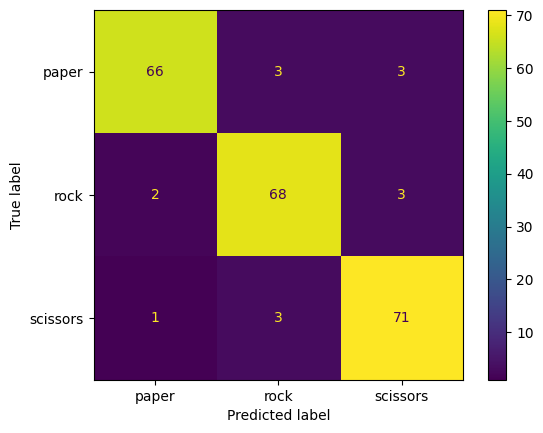

In [46]:
plot_stats(stats)
print(stats['elapsed_time'])
cm_plot(net, test_dl)

Size of tensor containing a batch of images is torch.Size([9, 3, 100, 150])


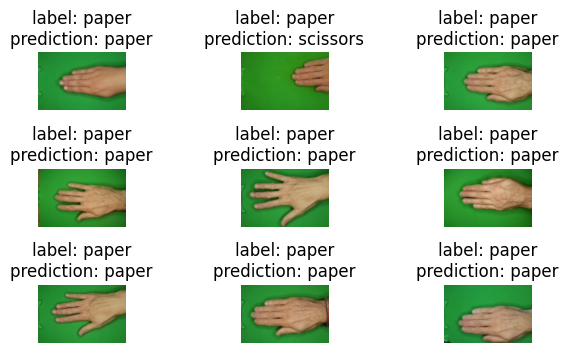

In [47]:
img,lbl=next(iter(test_dl))
inputs = img.to(device).float()
labels = lbl.to(device).float()

print('Size of tensor containing a batch of images is {}'.format(inputs.shape))

with torch.set_grad_enabled(False):
    outputs = net(inputs)


if (device=='cpu'):
    show_batch(img,lbl,outputs)
else:
    show_batch(img,lbl,outputs.cpu().numpy())



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8041722..1.082017].


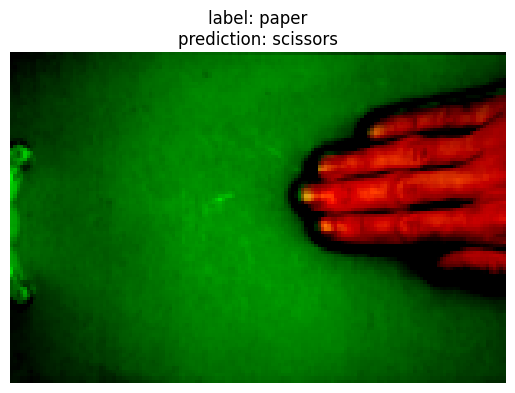

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8002932..2.3262649].


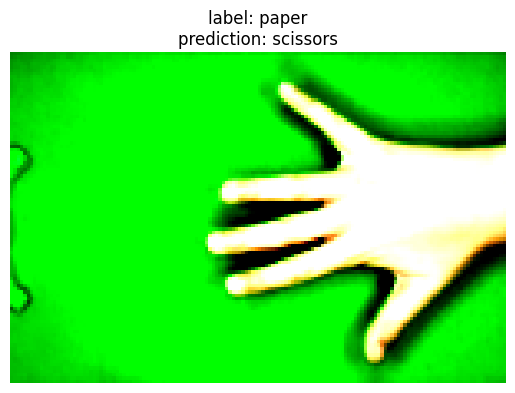

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8877901..1.3940086].


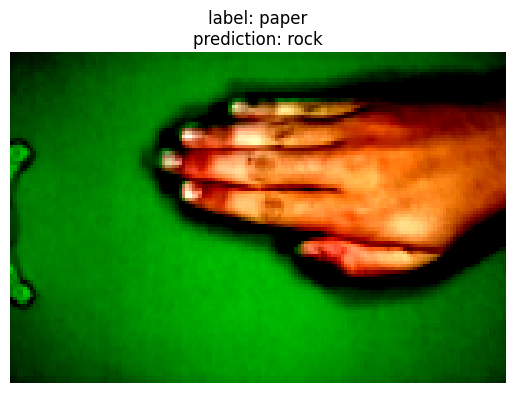

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1152282..1.8261408].


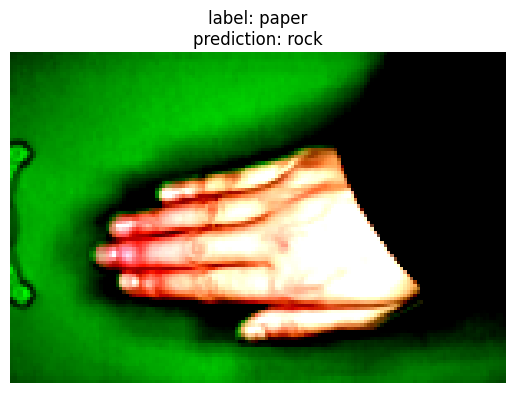

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8548784..1.8202546].


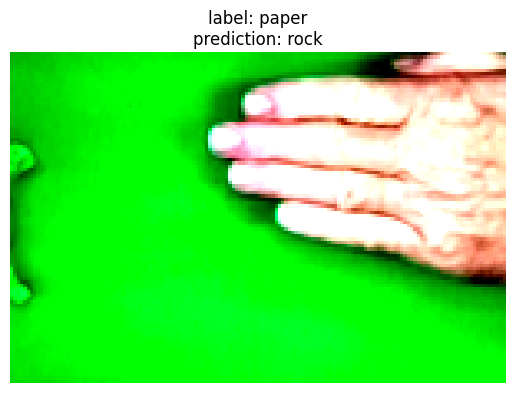

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8044444..1.1711189].


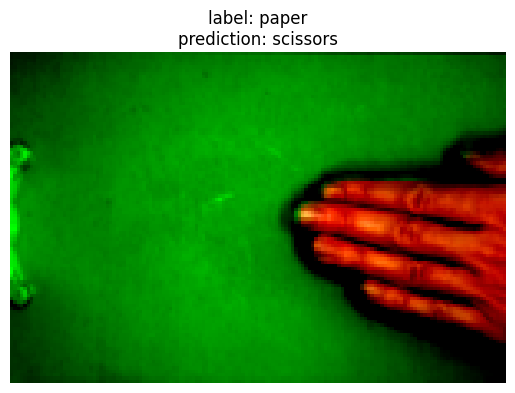

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7906607..1.7843993].


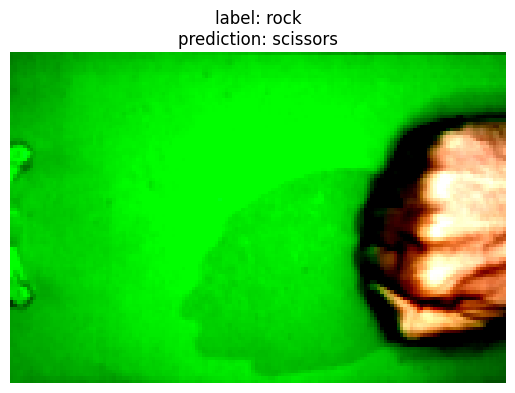

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7870152..1.5965621].


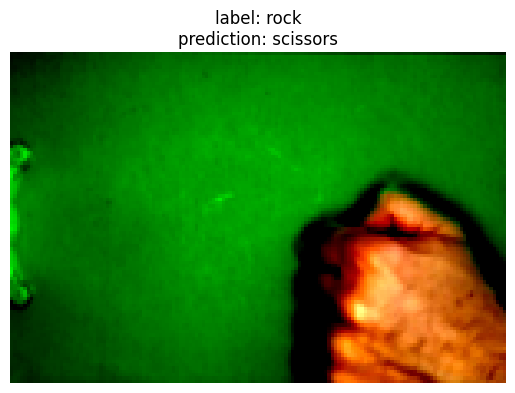

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8832413..1.7332927].


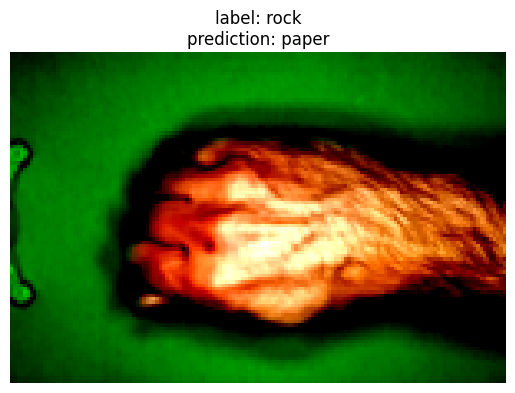

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0226476..2.2135885].


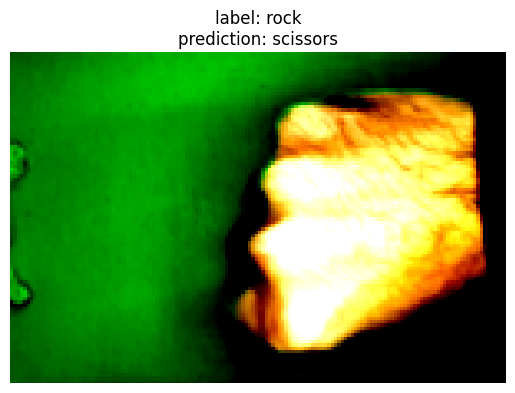

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.648204].


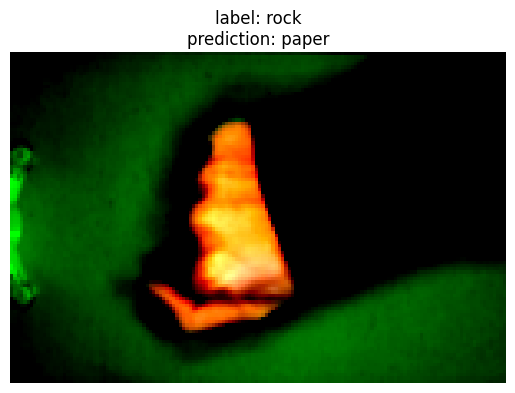

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0954278..1.6484714].


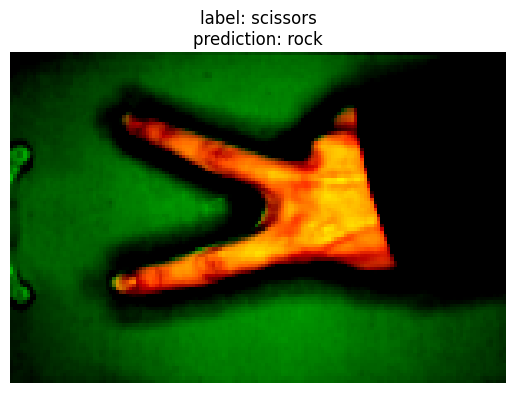

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1152282..2.0281591].


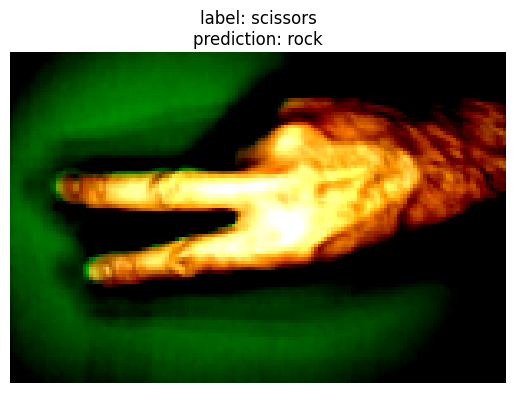

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.5382309].


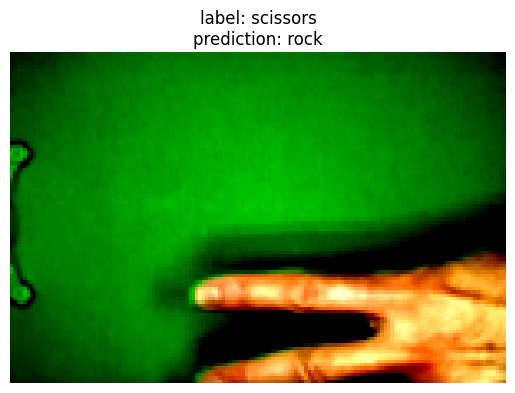

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.9711659].


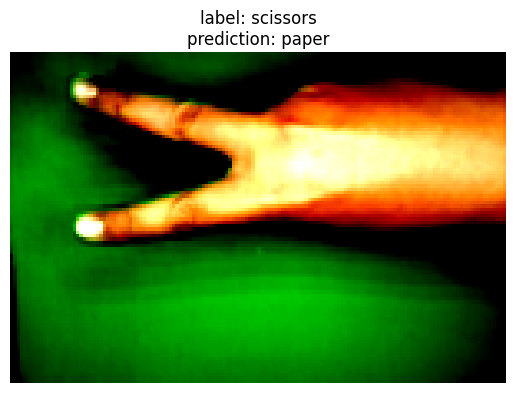

In [48]:
show_misclassified(net, test_dl)

# Hyperparameter tuning with nested cross validation and grid search

5it [09:35, 115.11s/it]0:00<?, ?it/s]


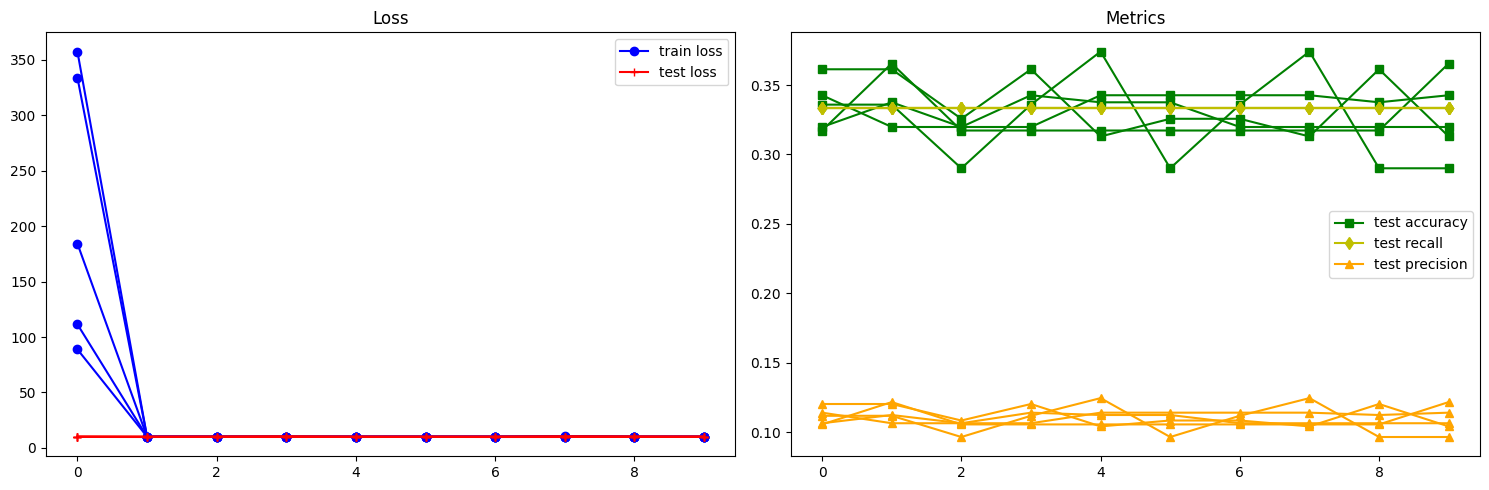

5it [09:29, 113.97s/it]9:35<1:16:46, 575.84s/it]


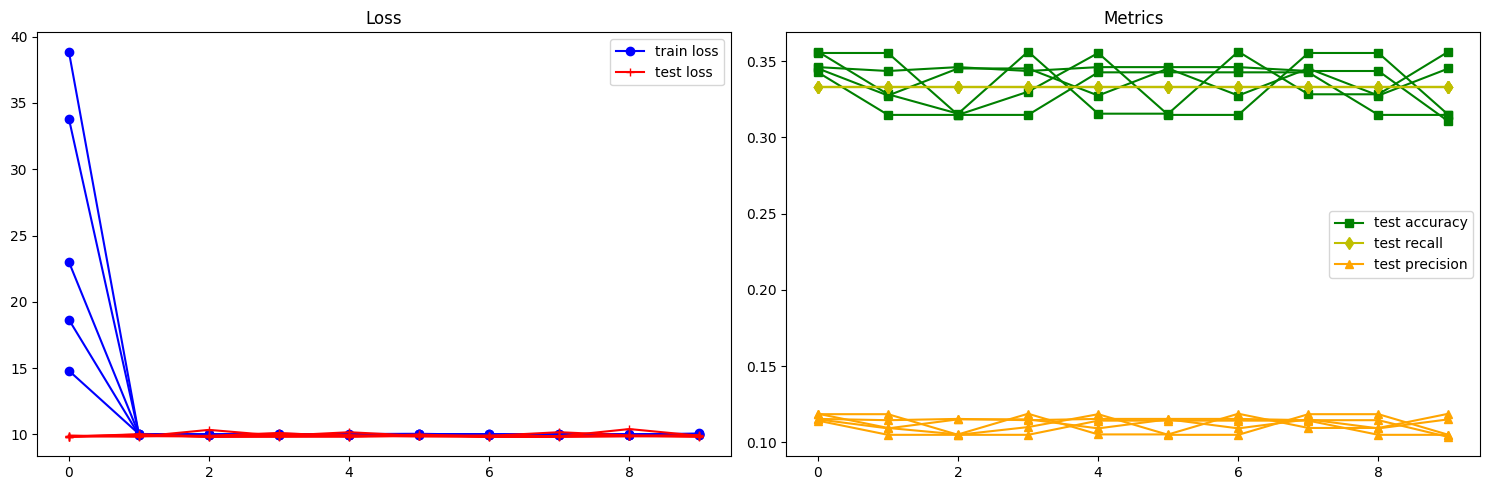

0it [00:00, ?it/s]/9 [19:05<1:06:47, 572.46s/it]
 22%|██▏       | 2/9 [19:06<1:06:52, 573.17s/it]


RuntimeError: non-positive stride is not supported

In [ ]:
from sklearn.model_selection import ParameterGrid


params = {
    'lr': [0.1, 1e-2, 1e-3],
    'model_params': [[5,2],[3,2],[3,1]],
}
nested_cv(model_class=EzNet, hyperparams=params, dataset=train_dataset, criterion=criterion, optimizer_class=optim.Adam, scheduler_class=lr_scheduler.StepLR, k=5)

# K-Fold Cross Validation

8it [18:41, 140.15s/it]


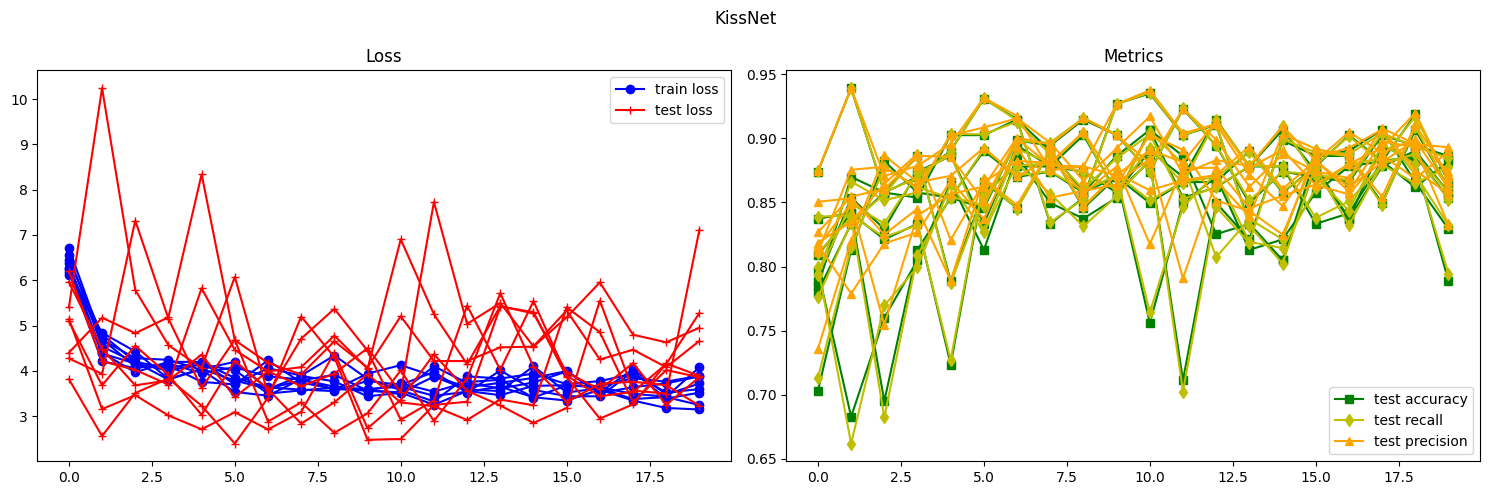

{'train_loss': {'KissNet': array([6.36097337, 4.56989906, 4.17388697, 4.05321763, 4.0429832 ,
       3.85876543, 3.74492155, 3.76347639, 3.7555469 , 3.65941757,
       3.66612291, 3.67641862, 3.65119025, 3.70850153, 3.7142618 ,
       3.67042992, 3.59356016, 3.70678092, 3.48863346, 3.6357118 ])}, 'test_acc': {'KissNet': array([0.796748  , 0.83434963, 0.82012206, 0.84908545, 0.84552854,
       0.8673781 , 0.8877033 , 0.8734757 , 0.86788625, 0.87804884,
       0.87500006, 0.85772365, 0.8739838 , 0.8495936 , 0.85569113,
       0.8704269 , 0.86737806, 0.8846545 , 0.8882114 , 0.8531504 ],
      dtype=float32)}, 'test_prec': {'KissNet': array([0.8187672 , 0.8506597 , 0.84470284, 0.8613858 , 0.86089545,
       0.87715906, 0.8908001 , 0.8819465 , 0.875896  , 0.883957  ,
       0.8861944 , 0.87576014, 0.88412976, 0.86387205, 0.87235916,
       0.878281  , 0.8761261 , 0.8894932 , 0.8949617 , 0.8681849 ],
      dtype=float32)}, 'test_rec': {'KissNet': array([0.79995894, 0.8305194 , 0.81904864, 0.

8it [20:50, 156.35s/it]


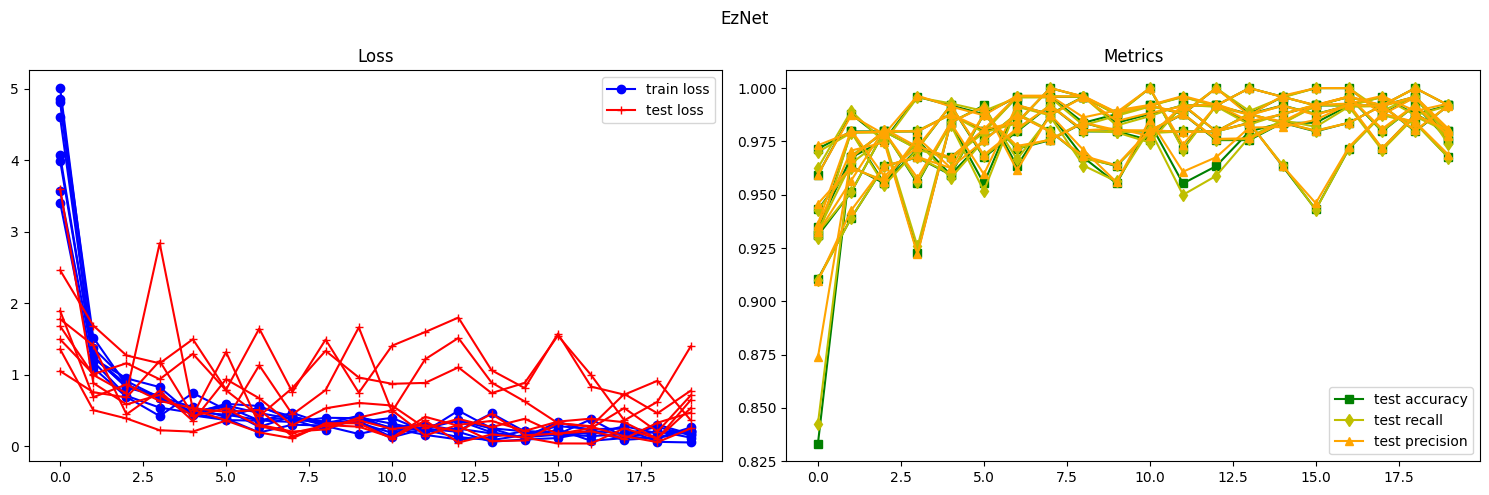

{'train_loss': {'KissNet': array([6.36097337, 4.56989906, 4.17388697, 4.05321763, 4.0429832 ,
       3.85876543, 3.74492155, 3.76347639, 3.7555469 , 3.65941757,
       3.66612291, 3.67641862, 3.65119025, 3.70850153, 3.7142618 ,
       3.67042992, 3.59356016, 3.70678092, 3.48863346, 3.6357118 ]), 'EzNet': array([4.29120426, 1.2698427 , 0.8290963 , 0.653069  , 0.50677331,
       0.4790624 , 0.39024474, 0.38728213, 0.31031746, 0.34882745,
       0.25433886, 0.23569183, 0.26409662, 0.20088018, 0.15583434,
       0.20694478, 0.20577447, 0.16441523, 0.18289783, 0.17290659])}, 'test_acc': {'KissNet': array([0.796748  , 0.83434963, 0.82012206, 0.84908545, 0.84552854,
       0.8673781 , 0.8877033 , 0.8734757 , 0.86788625, 0.87804884,
       0.87500006, 0.85772365, 0.8739838 , 0.8495936 , 0.85569113,
       0.8704269 , 0.86737806, 0.8846545 , 0.8882114 , 0.8531504 ],
      dtype=float32), 'EzNet': array([0.9268293 , 0.9669716 , 0.9705285 , 0.9674797 , 0.9781504 ,
       0.9781504 , 0.98373985, 0

8it [39:36, 297.02s/it]


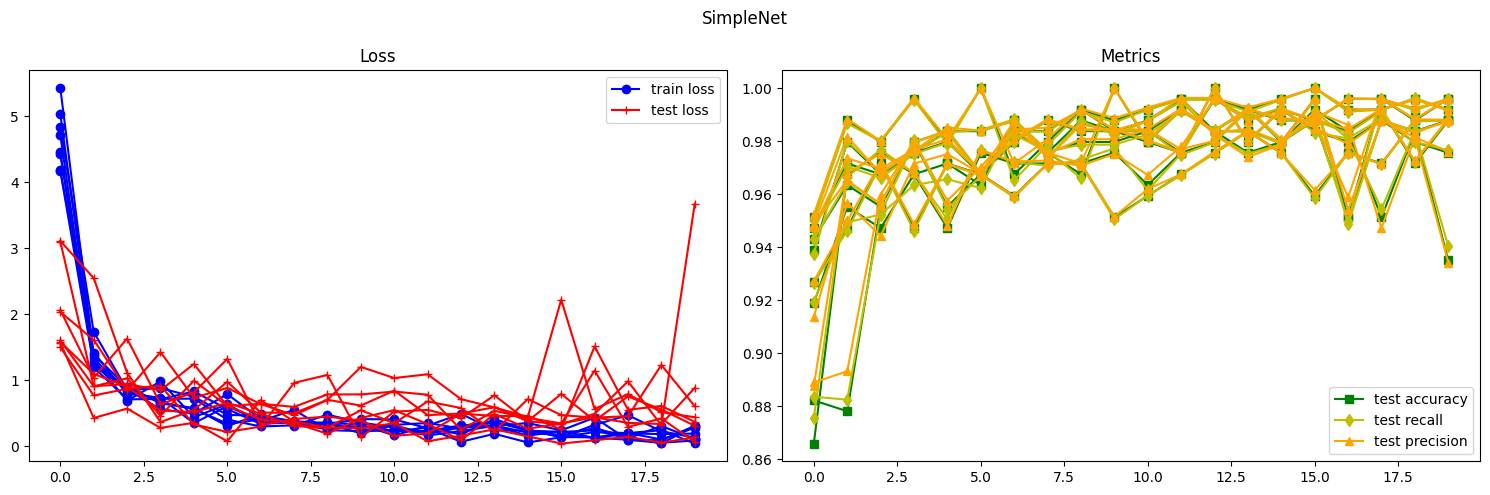

{'train_loss': {'KissNet': array([6.36097337, 4.56989906, 4.17388697, 4.05321763, 4.0429832 ,
       3.85876543, 3.74492155, 3.76347639, 3.7555469 , 3.65941757,
       3.66612291, 3.67641862, 3.65119025, 3.70850153, 3.7142618 ,
       3.67042992, 3.59356016, 3.70678092, 3.48863346, 3.6357118 ]), 'EzNet': array([4.29120426, 1.2698427 , 0.8290963 , 0.653069  , 0.50677331,
       0.4790624 , 0.39024474, 0.38728213, 0.31031746, 0.34882745,
       0.25433886, 0.23569183, 0.26409662, 0.20088018, 0.15583434,
       0.20694478, 0.20577447, 0.16441523, 0.18289783, 0.17290659]), 'SimpleNet': array([4.65671903, 1.35226209, 0.81301644, 0.73533329, 0.58863842,
       0.51281214, 0.39029388, 0.37074937, 0.33507432, 0.30200819,
       0.2710505 , 0.24953592, 0.26526772, 0.31067406, 0.21598655,
       0.17616446, 0.23214767, 0.18601257, 0.15357949, 0.17878549])}, 'test_acc': {'KissNet': array([0.796748  , 0.83434963, 0.82012206, 0.84908545, 0.84552854,
       0.8673781 , 0.8877033 , 0.8734757 , 0.8678

8it [37:14, 279.33s/it]


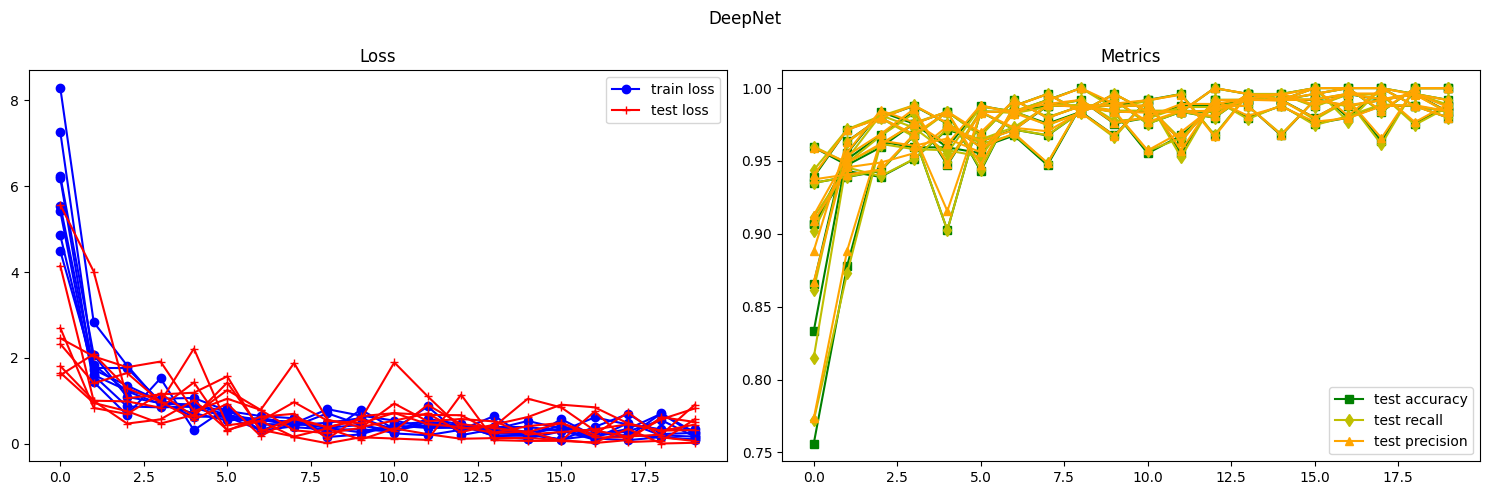

{'train_loss': {'KissNet': array([6.36097337, 4.56989906, 4.17388697, 4.05321763, 4.0429832 ,
       3.85876543, 3.74492155, 3.76347639, 3.7555469 , 3.65941757,
       3.66612291, 3.67641862, 3.65119025, 3.70850153, 3.7142618 ,
       3.67042992, 3.59356016, 3.70678092, 3.48863346, 3.6357118 ]), 'EzNet': array([4.29120426, 1.2698427 , 0.8290963 , 0.653069  , 0.50677331,
       0.4790624 , 0.39024474, 0.38728213, 0.31031746, 0.34882745,
       0.25433886, 0.23569183, 0.26409662, 0.20088018, 0.15583434,
       0.20694478, 0.20577447, 0.16441523, 0.18289783, 0.17290659]), 'SimpleNet': array([4.65671903, 1.35226209, 0.81301644, 0.73533329, 0.58863842,
       0.51281214, 0.39029388, 0.37074937, 0.33507432, 0.30200819,
       0.2710505 , 0.24953592, 0.26526772, 0.31067406, 0.21598655,
       0.17616446, 0.23214767, 0.18601257, 0.15357949, 0.17878549]), 'DeepNet': array([6.03123711, 1.85724589, 1.25468338, 1.02395454, 0.77941179,
       0.67957647, 0.48580594, 0.4839757 , 0.43508778, 0.468313

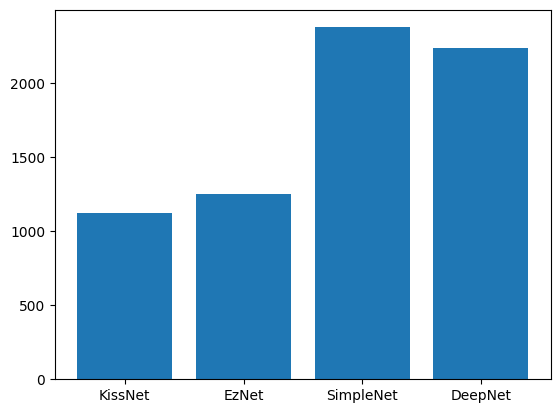

In [74]:
times = {}
tot_stats = {'train_loss':{},
             'test_acc':{},
             'test_acc':{},
             'test_prec':{},
             'test_rec':{}
             }
for model in KissNet, EzNet, SimpleNet, DeepNet:
    start_time = time.time()
    stats = cross_val(model, train_dataset, criterion, optim.Adam, lr_scheduler.StepLR, num_epochs=20, k=8)
    times[model.__name__] = time.time() - start_time
    plot_stats(stats, title=model.__name__)
    for s in tot_stats:
        tot_stats[s][model.__name__] = np.mean(stats[s], axis=0)
    print(tot_stats)

plt.bar( times.keys(), times.values())
plt.show()

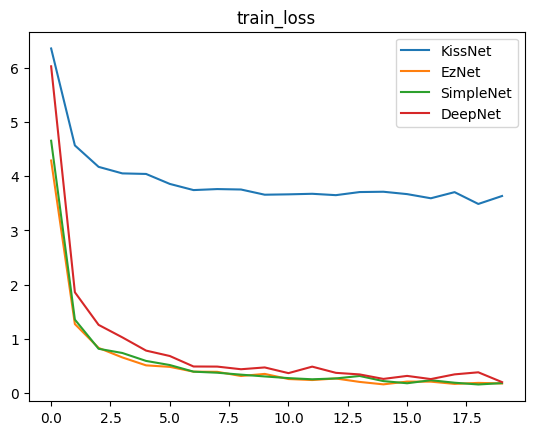

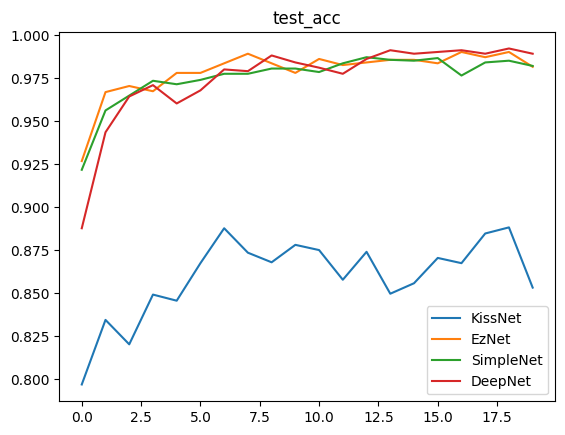

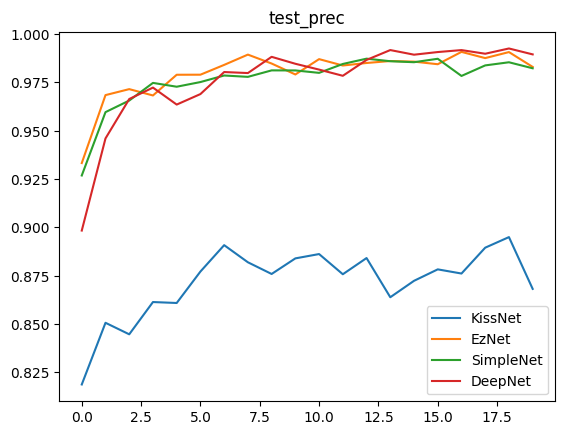

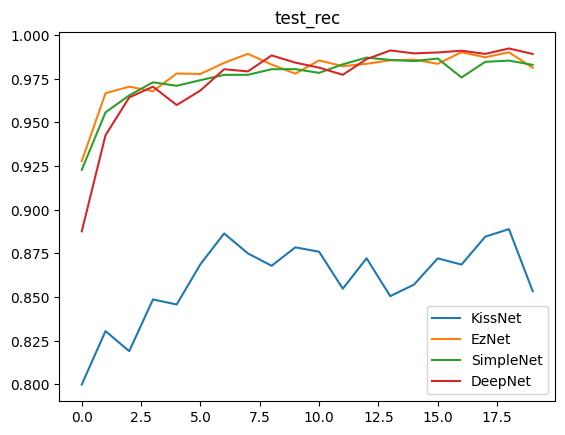

In [95]:
for s in tot_stats:
    for net in tot_stats[s]:
        plt.plot(tot_stats[s][net], label=net)
    plt.title(s)
    plt.legend()
    plt.show()

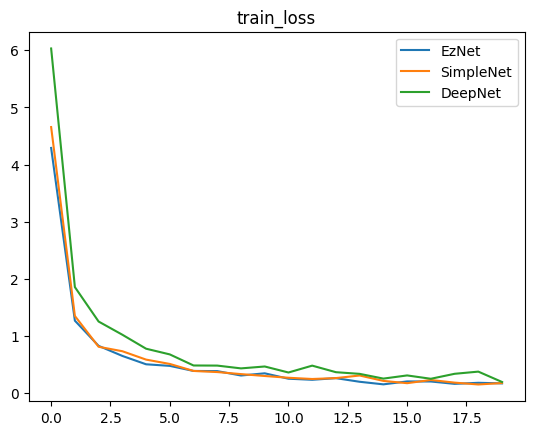

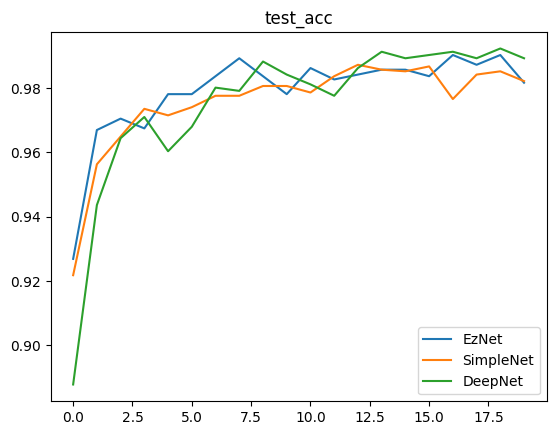

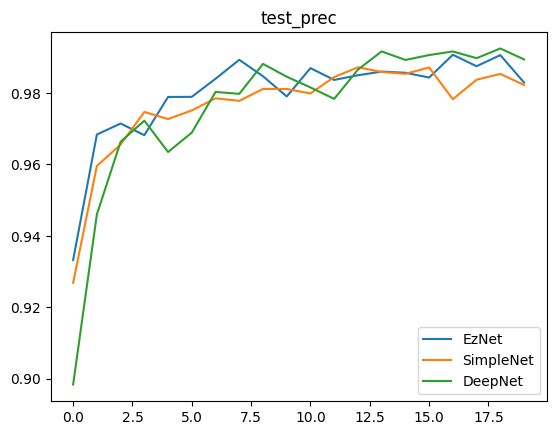

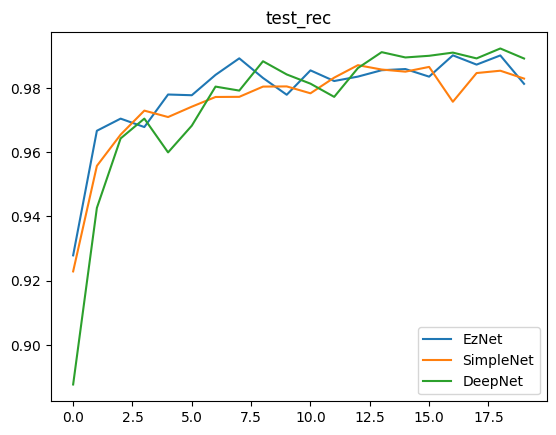

In [94]:
for s in tot_stats:
    for net in tot_stats[s]:
        if (net!='KissNet'):
            plt.plot(tot_stats[s][net], label=net)
    plt.title(s)
    plt.legend()
    plt.show()

# Generalizing capabilities

Number of test batches: 5


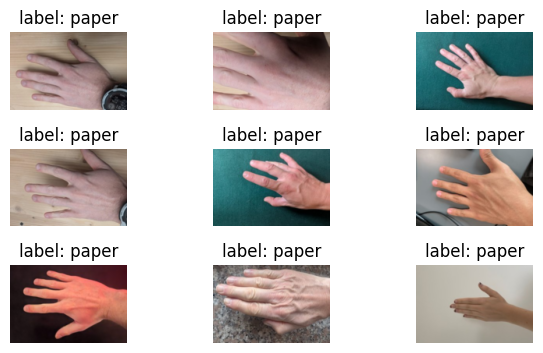

In [127]:
gen_test_dataset = datasets.ImageFolder(root='generalized_dataset', transform=gen_test_transform)
gen_test_dl = DataLoader(gen_test_dataset, batch_size=batch_size)
print('Number of test batches: {}'.format(len(gen_test_dl)))
show_batch(*next(iter(gen_test_dl)))

Epoch 0/9
----------


Train loss: 9.3970
Test loss: 22.1917
Test accuracy: 0.2750
Test precision: 0.2604
Test recall: 0.2802
Epoch 1/9
----------


Train loss: 8.6668
Test loss: 22.4153
Test accuracy: 0.3500
Test precision: 0.3634
Test recall: 0.3498
Epoch 2/9
----------


Train loss: 9.0065
Test loss: 25.8594
Test accuracy: 0.2750
Test precision: 0.1903
Test recall: 0.2821
Epoch 3/9
----------


Train loss: 8.0637
Test loss: 24.4270
Test accuracy: 0.2750
Test precision: 0.2667
Test recall: 0.2802
Epoch 4/9
----------


Train loss: 7.8721
Test loss: 26.3997
Test accuracy: 0.3500
Test precision: 0.3393
Test recall: 0.3462
Epoch 5/9
----------


Train loss: 7.6140
Test loss: 25.1309
Test accuracy: 0.2250
Test precision: 0.2239
Test recall: 0.2271
Epoch 6/9
----------


Train loss: 8.4806
Test loss: 25.5620
Test accuracy: 0.3500
Test precision: 0.3564
Test recall: 0.3535
Epoch 7/9
----------


Train loss: 8.5741
Test loss: 30.0798
Test accuracy: 0.3000
Test precision: 0.2917
Test recall: 0.3040
Epoch 8/9
----------


Train loss: 8.6500
Test loss: 30.0873
Test accuracy: 0.3000
Test precision: 0.3000
Test recall: 0.2985
Epoch 9/9
----------


Train loss: 7.8345
Test loss: 28.2640
Test accuracy: 0.2500
Test precision: 0.2291
Test recall: 0.2546


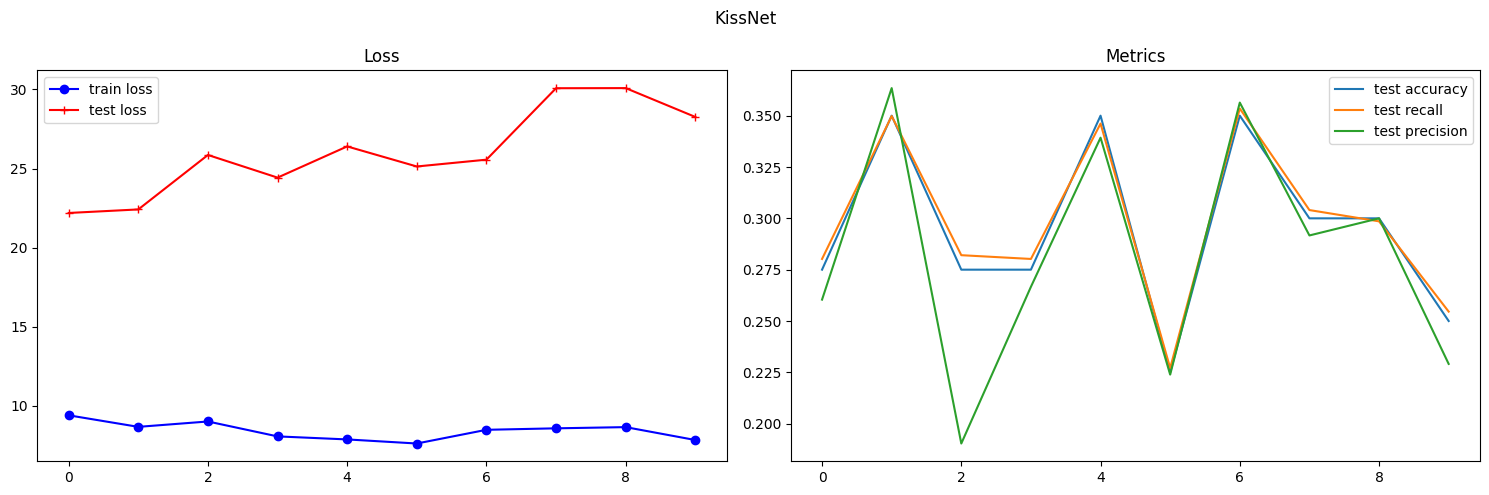

120.5227165222168


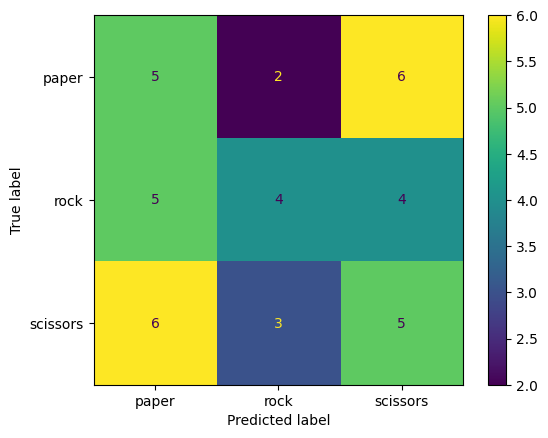

Epoch 0/9
----------


Train loss: 9.2469
Test loss: 18.5156
Test accuracy: 0.3250
Test precision: 0.3694
Test recall: 0.3297
Epoch 1/9
----------


Train loss: 3.9418
Test loss: 23.2597
Test accuracy: 0.4000
Test precision: 0.3704
Test recall: 0.4048
Epoch 2/9
----------


Train loss: 2.2974
Test loss: 9.6428
Test accuracy: 0.5000
Test precision: 0.4911
Test recall: 0.5055
Epoch 3/9
----------


Train loss: 1.3309
Test loss: 14.8580
Test accuracy: 0.6000
Test precision: 0.6628
Test recall: 0.6081
Epoch 4/9
----------


Train loss: 1.1377
Test loss: 10.6707
Test accuracy: 0.5250
Test precision: 0.5222
Test recall: 0.5293
Epoch 5/9
----------


Train loss: 0.8173
Test loss: 20.9054
Test accuracy: 0.5500
Test precision: 0.5556
Test recall: 0.5604
Epoch 6/9
----------


Train loss: 1.0995
Test loss: 12.9079
Test accuracy: 0.5500
Test precision: 0.5222
Test recall: 0.5604
Epoch 7/9
----------


Train loss: 0.6728
Test loss: 12.7137
Test accuracy: 0.5750
Test precision: 0.6500
Test recall: 0.5842
Epoch 8/9
----------


Train loss: 0.6425
Test loss: 11.7683
Test accuracy: 0.5750
Test precision: 0.6216
Test recall: 0.5788
Epoch 9/9
----------


Train loss: 0.4595
Test loss: 16.4556
Test accuracy: 0.5750
Test precision: 0.6705
Test recall: 0.5824


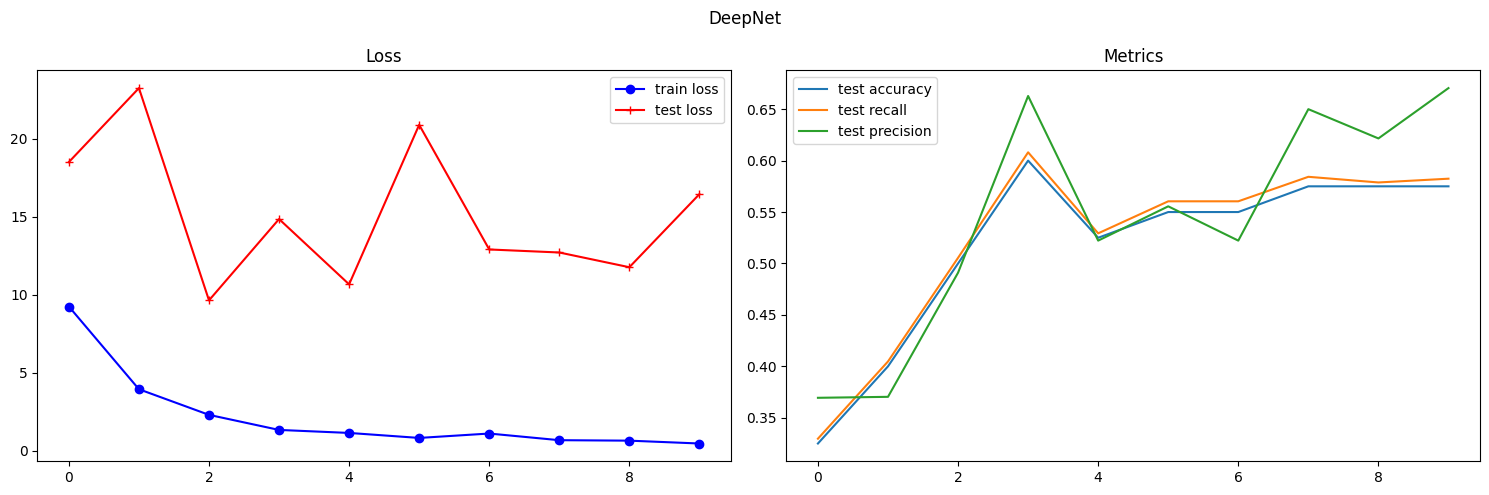

187.42529344558716


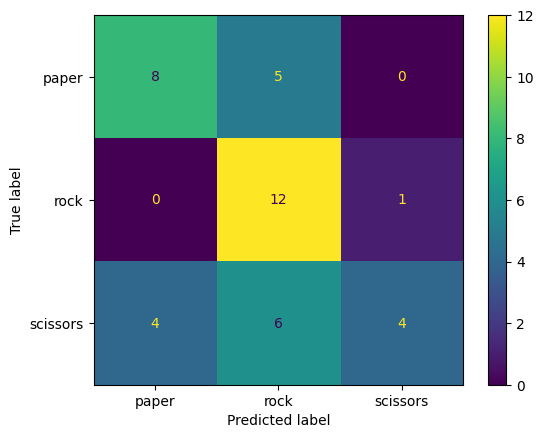

Epoch 0/9
----------


Train loss: 6.1038
Test loss: 19.1505
Test accuracy: 0.4250
Test precision: 0.5799
Test recall: 0.4121
Epoch 1/9
----------


Train loss: 2.4958
Test loss: 12.4449
Test accuracy: 0.4000
Test precision: 0.4583
Test recall: 0.4011
Epoch 2/9
----------


Train loss: 1.7783
Test loss: 11.1879
Test accuracy: 0.4000
Test precision: 0.4039
Test recall: 0.4011
Epoch 3/9
----------


Train loss: 1.3098
Test loss: 10.9422
Test accuracy: 0.4250
Test precision: 0.4339
Test recall: 0.4267
Epoch 4/9
----------


Train loss: 1.1904
Test loss: 10.1255
Test accuracy: 0.5500
Test precision: 0.5517
Test recall: 0.5513
Epoch 5/9
----------


Train loss: 0.9931
Test loss: 11.0123
Test accuracy: 0.5500
Test precision: 0.5500
Test recall: 0.5568
Epoch 6/9
----------


Train loss: 0.7907
Test loss: 9.8423
Test accuracy: 0.6000
Test precision: 0.6310
Test recall: 0.5989
Epoch 7/9
----------


Train loss: 0.7341
Test loss: 10.2098
Test accuracy: 0.5750
Test precision: 0.6319
Test recall: 0.5769
Epoch 8/9
----------


Train loss: 0.5735
Test loss: 15.8240
Test accuracy: 0.4500
Test precision: 0.3948
Test recall: 0.4597
Epoch 9/9
----------


Train loss: 0.5914
Test loss: 10.6544
Test accuracy: 0.5250
Test precision: 0.5302
Test recall: 0.5311


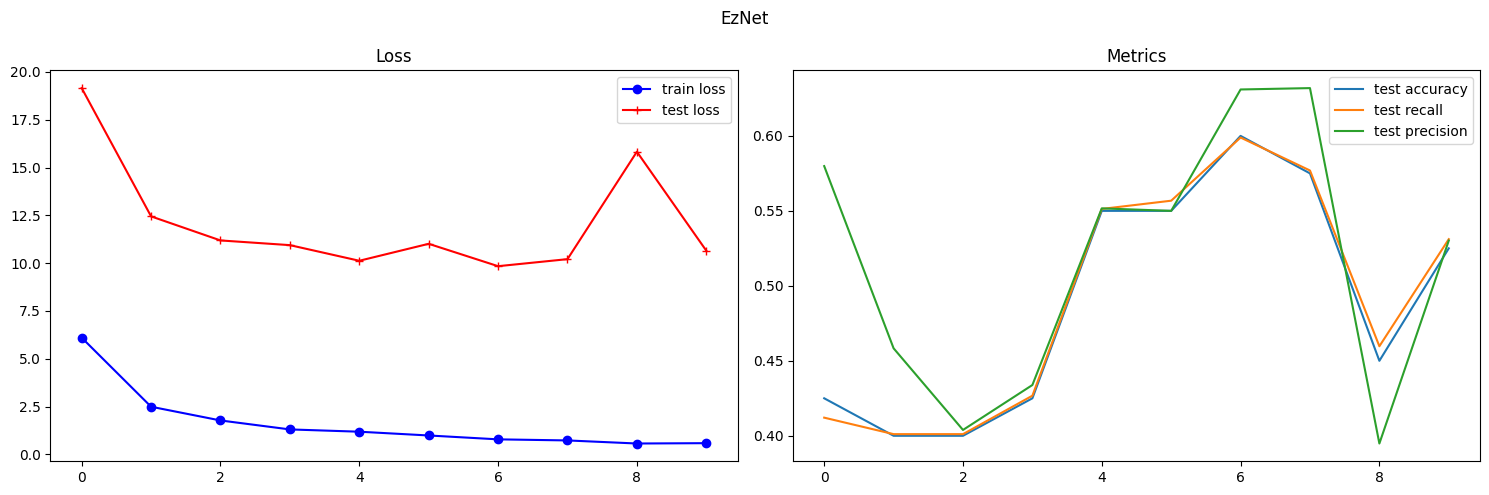

124.20251607894897


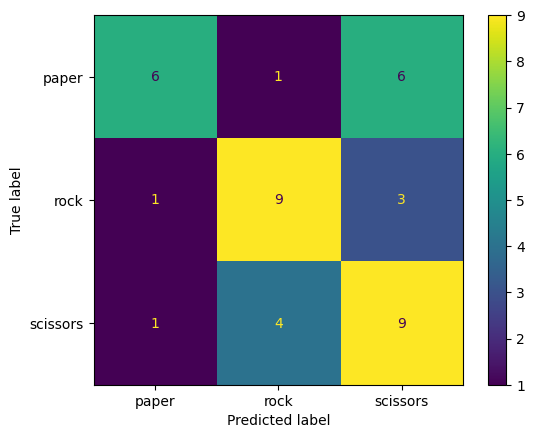

Epoch 0/9
----------


Train loss: 6.0365
Test loss: 23.9628
Test accuracy: 0.4000
Test precision: 0.6238
Test recall: 0.3864
Epoch 1/9
----------


Train loss: 2.5667
Test loss: 15.3079
Test accuracy: 0.4000
Test precision: 0.4027
Test recall: 0.4029
Epoch 2/9
----------


Train loss: 1.7791
Test loss: 28.0085
Test accuracy: 0.4500
Test precision: 0.6646
Test recall: 0.4377
Epoch 3/9
----------


Train loss: 1.5518
Test loss: 23.6677
Test accuracy: 0.5250
Test precision: 0.6524
Test recall: 0.5147
Epoch 4/9
----------


Train loss: 1.0996
Test loss: 28.1840
Test accuracy: 0.5250
Test precision: 0.6569
Test recall: 0.5238
Epoch 5/9
----------


Train loss: 0.9739
Test loss: 36.2595
Test accuracy: 0.5000
Test precision: 0.6953
Test recall: 0.4890
Epoch 6/9
----------


Train loss: 0.9154
Test loss: 22.8055
Test accuracy: 0.6000
Test precision: 0.7358
Test recall: 0.5934
Epoch 7/9
----------


Train loss: 0.8165
Test loss: 18.1003
Test accuracy: 0.4500
Test precision: 0.6151
Test recall: 0.4505
Epoch 8/9
----------


Train loss: 0.5150
Test loss: 38.0692
Test accuracy: 0.5000
Test precision: 0.6796
Test recall: 0.4908
Epoch 9/9
----------


Train loss: 0.7209
Test loss: 27.4343
Test accuracy: 0.4500
Test precision: 0.6282
Test recall: 0.4432


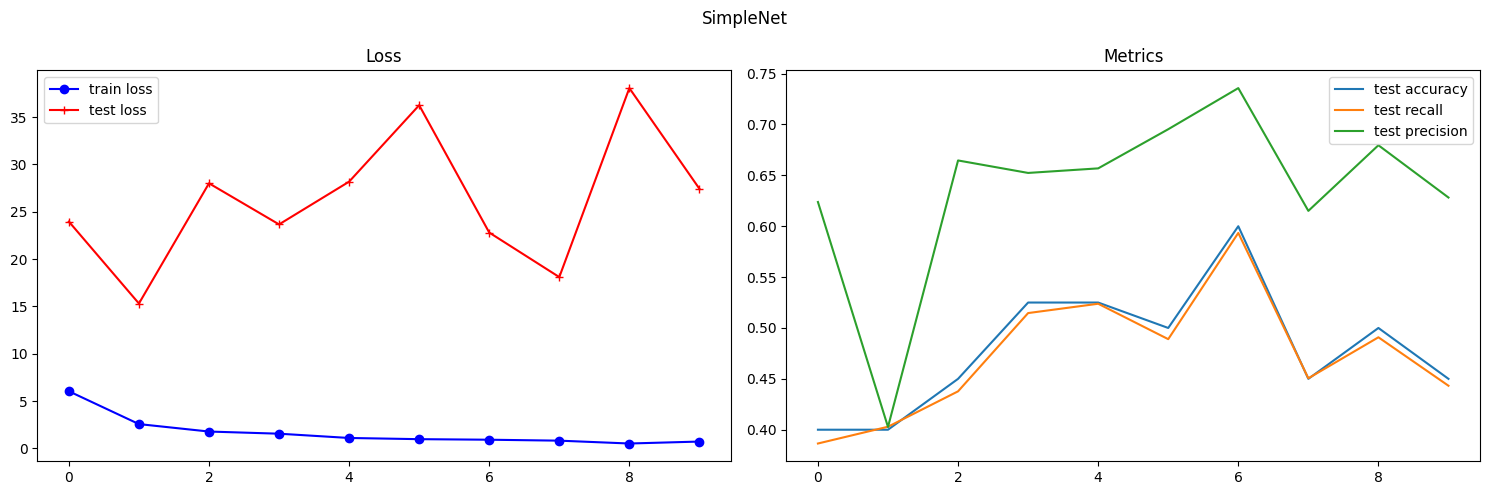

222.554425239563


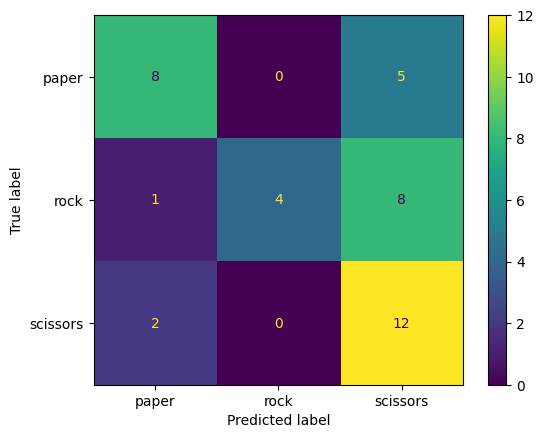

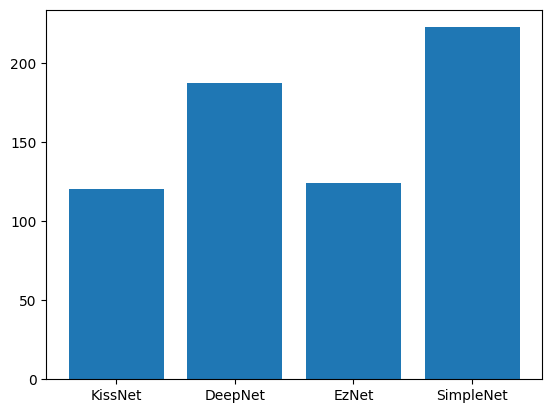

In [132]:
times = {}
for model in [KissNet, DeepNet, EzNet, SimpleNet]:
    net = model()
    net.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer_ft = optim.Adam(net.parameters(), lr=1e-3)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

    dls = {'train' : train_dl, 'test': gen_test_dl}
    stats = train_model(net, dls, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)
    plot_stats(stats, title=model.__name__)
    print(stats['elapsed_time'])
    times[model.__name__] = stats['elapsed_time']
    cm_plot(net, gen_test_dl)

plt.bar(times.keys(), times.values())
plt.show()

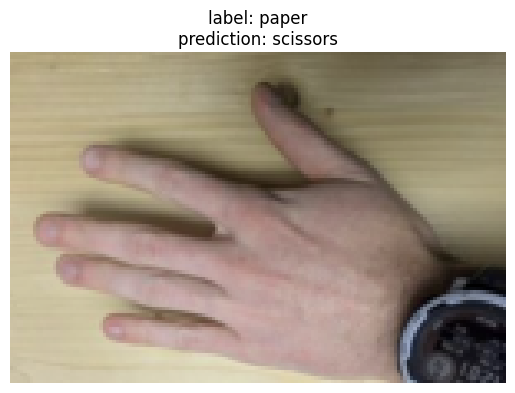

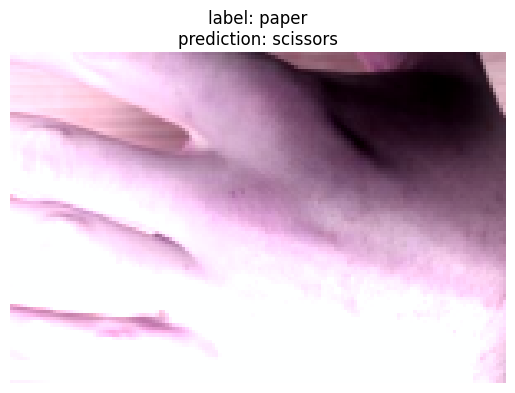

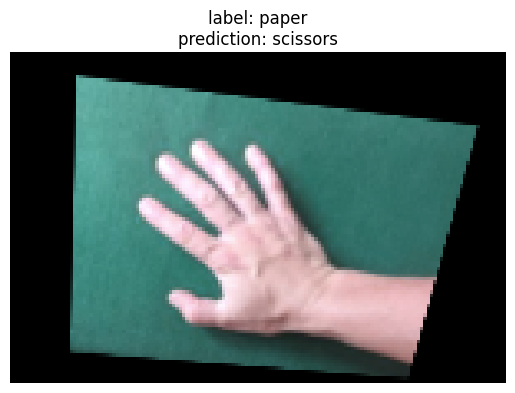

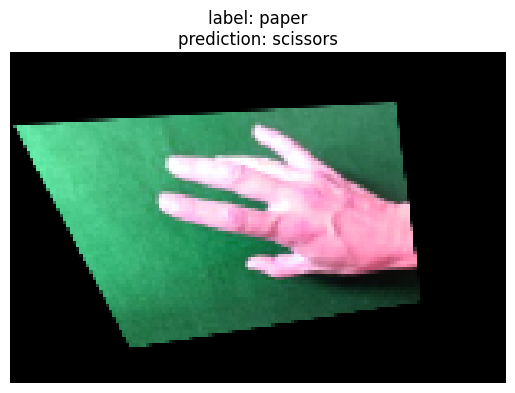

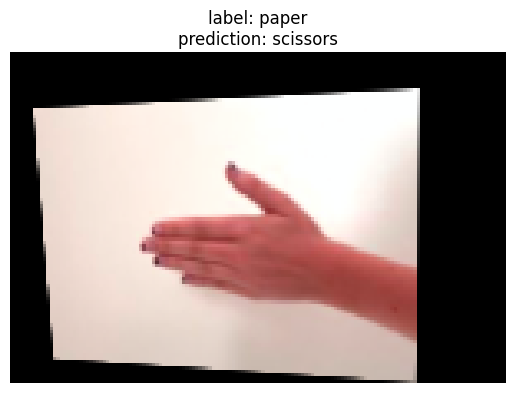

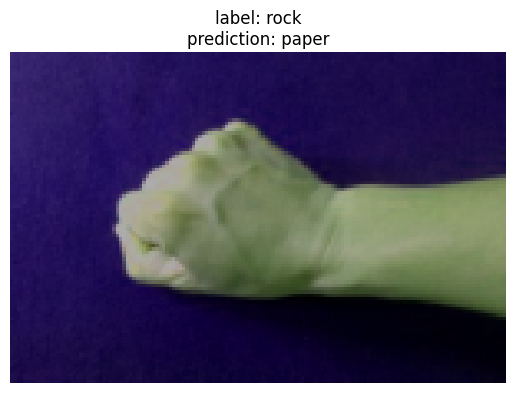

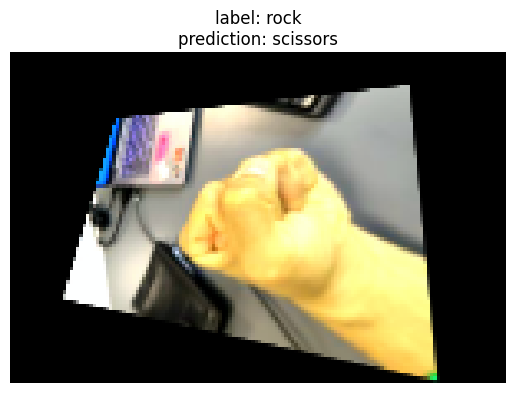

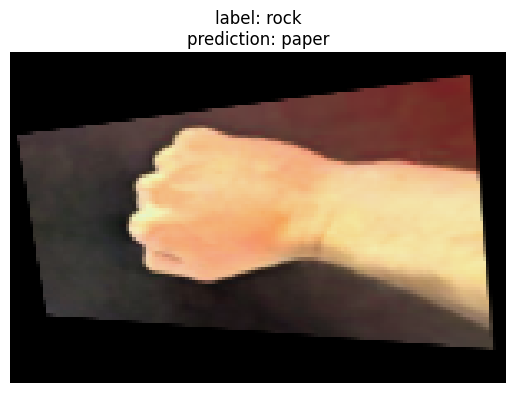

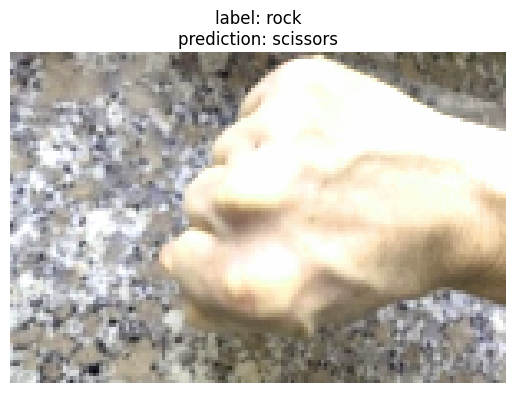

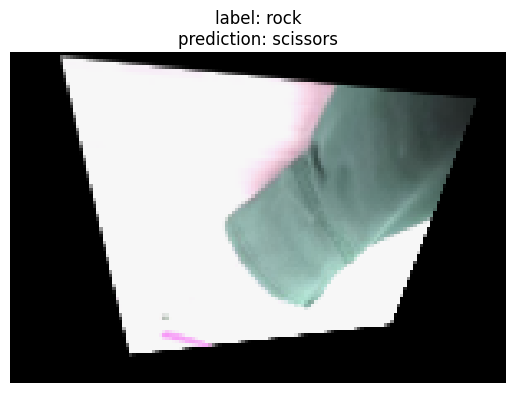

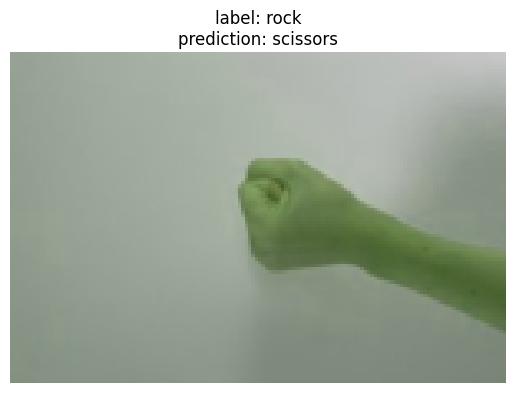

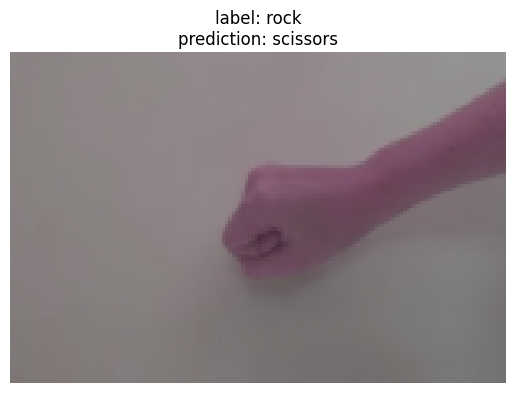

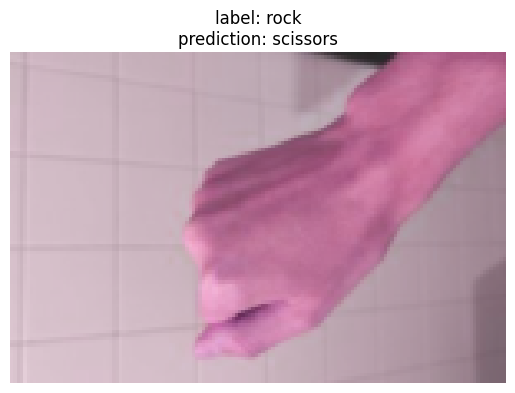

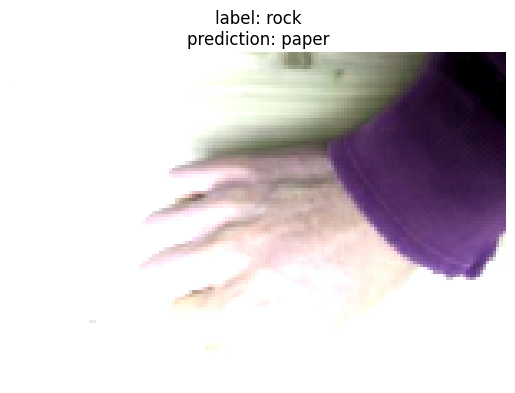

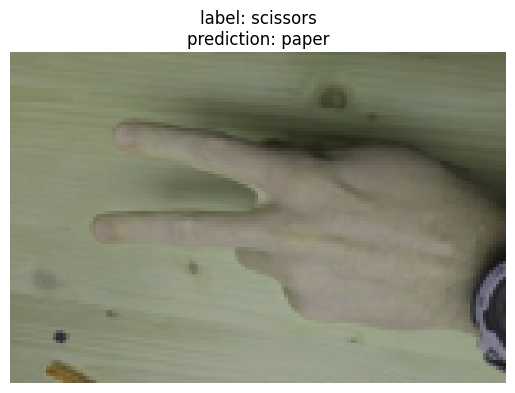

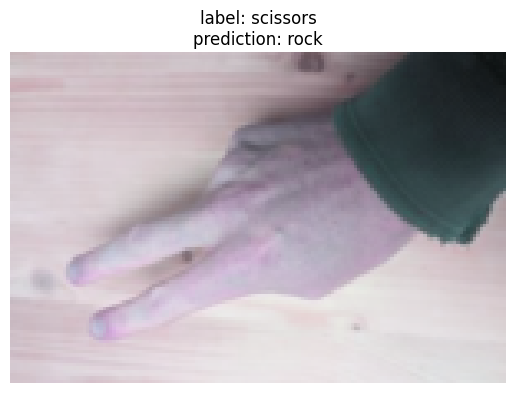

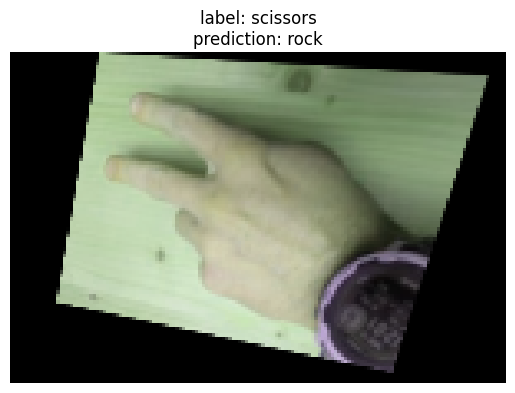

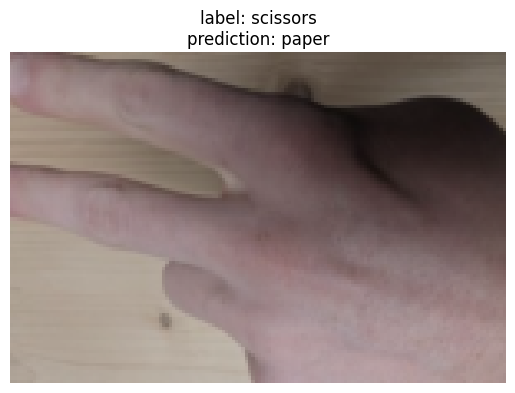

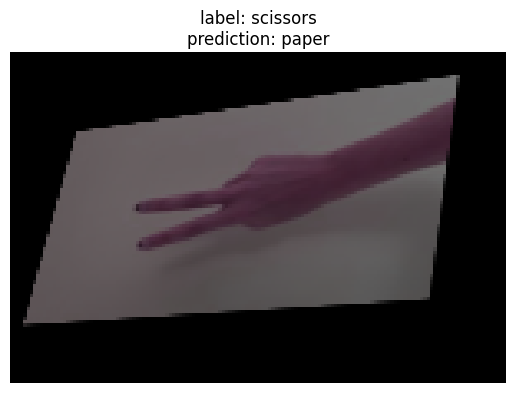

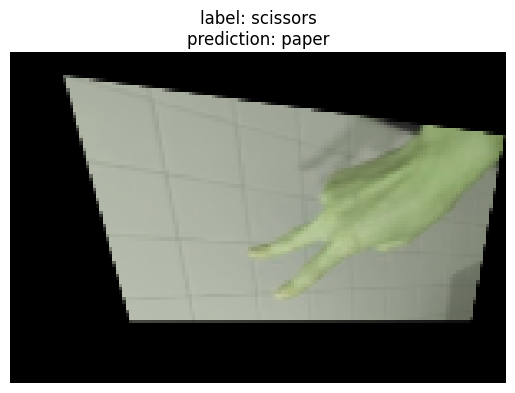

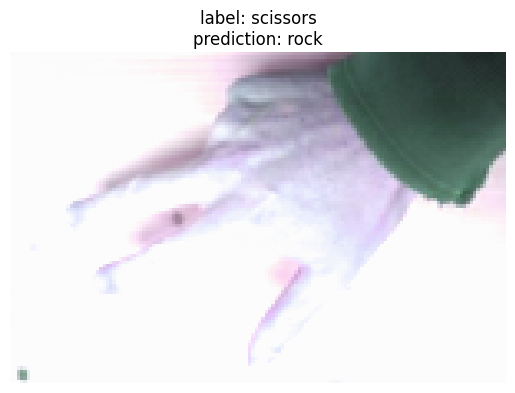

In [113]:
show_misclassified(net, gen_test_dl)